In [1]:
__depends__ = [
    "../data/sr15_scenarios/sr15_scenarios.csv",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UVIC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_BERN.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_LLNL.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CCSM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CLIMBER.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_MPI.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_FRCGC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UMD2.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_HADLEY.CFG",
    "utils_openscm.py",
    "utils_plotting.py",
    "utils_magcfg.py",
    "utils_config.py",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CCCMA_CGCM3_1_T47.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CNRM_CM3.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CSIRO_MK3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GFDL_CM2_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GFDL_CM2_1.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GISS_MODEL_E_H.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GISS_MODEL_E_R.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_IAP_FGOALS1_0_G.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_INMCM3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_IPSL_CM4.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIROC3_2_HIRES.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIROC3_2_MEDRES.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIUB_ECHO_G.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MPI_ECHAM5.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MRI_CGCM2_3_2A.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_NCAR_CCSM3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_NCAR_PCM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_UKMO_HADCM3.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_UKMO_HADGEM1.CFG",
]
__dest__ = [
    "../outputs/offline_budget_runs_tcre.h5",
    "../outputs/offline_budget_runs_zec.h5",
    "../outputs/offline_budget_runs_no_permafrost.h5",
    "../outputs/offline_budget_runs_co2_only.h5",
]

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [3]:
SCENARIO_PATH = __depends__[0]
CARBON_CYCLE_FILES = {
    "UVIC": __depends__[1],
    "BERN": __depends__[2],
    "LLNL": __depends__[3],
    "CCSM1": __depends__[4],
    "CLIMBER": __depends__[5],
    "MPI": __depends__[6],
    "FRCGC": __depends__[7],
    "UMD2": __depends__[8],
    "HADLEY": __depends__[9],
}
OCEAN_TUNING_FILES = {
    "CCCMA_CGCM3_1_T47": __depends__[14],
    "CNRM_CM3": __depends__[15],
    "CSIRO_MK3_0": __depends__[16],
    "GFDL_CM2_0": __depends__[17],
    "GFDL_CM2_1": __depends__[18],
    "GISS_MODEL_E_H": __depends__[19],
    "GISS_MODEL_E_R": __depends__[20],
    "IAP_FGOALS1_0_G": __depends__[21],
    "INMCM3_0": __depends__[22],
    "IPSL_CM4": __depends__[23],
    "MIROC3_2_HIRES": __depends__[24],
    "MIROC3_2_MEDRES": __depends__[25],
    "MIUB_ECHO_G": __depends__[26],
    "MPI_ECHAM5": __depends__[27],
    "MRI_CGCM2_3_2A": __depends__[28],
    "NCAR_CCSM3_0": __depends__[29],
    "NCAR_PCM1": __depends__[30],
    "UKMO_HADCM3": __depends__[31],
    "UKMO_HADGEM1": __depends__[32],
}
OUTPUT_RUNS_TCRE = __dest__[0]
OUTPUT_RUNS_ZEC = __dest__[1]
OUTPUT_RUNS_NO_PERMAFROST = __dest__[2]
OUTPUT_RUNS_CO2_ONLY = __dest__[3]

<IPython.core.display.Javascript object>

# Offline Budget Runs

In this notebook we perform the runs for the calculation of our offline budget.

## Imports

In [4]:
import os
from os.path import join
import datetime
import copy
from distutils.util import strtobool

import numpy as np
from openscm.scmdataframe import df_append, ScmDataFrame
from pymagicc import zero_emissions, rcp45, MAGICC6
from pymagicc.io import MAGICCData

from utils_openscm import save_scmdataframe, run_magicc6_with_scenarios
from utils_magcfg import get_carbon_cycle_cfgs, get_ocean_tuning_cfgs
from utils_config import TEST_RUN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting config

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from utils_plotting import setup

setup()

<IPython.core.display.Javascript object>

## Constants

In [6]:
SHOW_PLOTS = True and not strtobool(
    os.getenv("CI", "False")
)  # turn on if using the notebooks interactively

CARBON_CYCLES = get_carbon_cycle_cfgs(CARBON_CYCLE_FILES)
OCEAN_TUNINGS = get_ocean_tuning_cfgs(OCEAN_TUNING_FILES)

<IPython.core.display.Javascript object>

## Read in scenarios

In [7]:
scenarios = ScmDataFrame(SCENARIO_PATH)

<IPython.core.display.Javascript object>

### TCRE calculation

The TCRE is calculated from a prescribed 70-year 1%/yr increasing CO$_2$ concentration experiment. At the end of this experiment, CO$_2$ concentrations have approximately doubled. For our own interest in the zero emissions commitment, we switch to a zero emissions scenario thereafter. 

We perform this calculation for multiple carbon cycle tunings for robustness analysis in later assessment.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


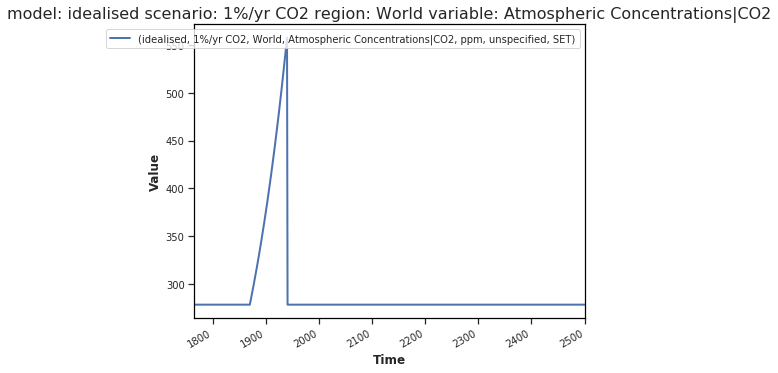

<IPython.core.display.Javascript object>

In [8]:
time = zero_emissions["time"]

rise_start_year = 1870
rise_years = 70
rise_start_idx = [t.year for t in time].index(rise_start_year)
rise_end_idx = rise_start_idx + rise_years
co2_concs = 278 * np.ones_like(time)
co2_concs[rise_start_idx : rise_end_idx + 1] = 278 * np.logspace(
    0, 70, num=rise_years + 1, base=1.01
)

co2_concs = MAGICCData(
    co2_concs,
    index=time,
    columns={
        "scenario": ["1%/yr CO2"],
        "model": ["idealised"],
        "climate_model": ["unspecified"],
        "variable": ["Atmospheric Concentrations|CO2"],
        "unit": ["ppm"],
        "todo": ["SET"],
        "region": ["World"],
    },
)

time = co2_concs["time"]
co2_concs.metadata = {"header": "1%/yr atmospheric CO2 concentration increase"}
if SHOW_PLOTS:
    co2_concs.line_plot(x="time")

In [9]:
def do_onepctco2_run(m, co2_conc_filename, oconfs):
    settings = {
        "file_co2_conc": co2_conc_filename,
        "co2_switchfromconc2emis_year": rise_start_year + rise_years,
        "co2_tempfeedback_switch": 1,
        "co2_tempfeedback_yrstart": rise_start_year,
        "co2_fertilization_yrstart": rise_start_year,
        "rf_total_runmodus": "CO2",
        "rf_total_constantafteryr": max(time).year,
        "endyear": max(time).year,
        "out_inverseemis": 1,
        **oconfs,
    }
    magicc.set_config(**{k: v for k, v in settings.items() if k != "endyear"})
    run_results = magicc.run(scen, endyear=settings["endyear"])
    for k, v in settings.items():
        run_results.set_meta(v, k)
        
    return run_results

<IPython.core.display.Javascript object>

In [10]:
scen = copy.deepcopy(zero_emissions)
scen.set_meta("1%/yr CO2", "scenario")
scen.set_meta("Idealised", "model")
tcre_diagnosis = []
with MAGICC6() as magicc:
    co2_conc_filename = "1PCT_CO2_CONC.IN"
    co2_concs.write(join(magicc.run_dir, co2_conc_filename), magicc.version)
    for cc, cc_config in CARBON_CYCLES.items():
        print(cc)
        run_results = do_onepctco2_run(magicc, co2_conc_filename, cc_config)
        run_results.set_meta(cc, name="carbon_cycle_tuning")
        tcre_diagnosis.append(run_results)
        
    for oc, oc_config in OCEAN_TUNINGS.items():
        print(oc)
        run_results = do_onepctco2_run(magicc, co2_conc_filename, oc_config)
        run_results.set_meta(oc, name="ocean_tuning")
        tcre_diagnosis.append(run_results)

tcre_diagnosis = df_append(tcre_diagnosis)
save_scmdataframe(tcre_diagnosis.filter(region="World"), OUTPUT_RUNS_TCRE)

UVIC


Ignoring input data which is not required for .SCEN file


BERN
LLNL
CCSM1
CLIMBER
MPI
FRCGC
UMD2
HADLEY
default
CCCMA_CGCM3_1_T47
CNRM_CM3
CSIRO_MK3_0
GFDL_CM2_0
GFDL_CM2_1
GISS_MODEL_E_H
GISS_MODEL_E_R
IAP_FGOALS1_0_G
INMCM3_0
IPSL_CM4
MIROC3_2_HIRES
MIROC3_2_MEDRES
MIUB_ECHO_G
MPI_ECHAM5
MRI_CGCM2_3_2A
NCAR_CCSM3_0
NCAR_PCM1
UKMO_HADCM3
UKMO_HADGEM1


numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<IPython.core.display.Javascript object>

In [11]:
tcre_diagnosis.filter(variable="Surface Temperature", region="World").timeseries()

time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1765-01-01 00:00:00  \
model     scenario  region variable            unit carbon_cycle_tuning climate_model co2_detrituspool_initial co2_feedbackfactor_detritus co2_feedbackfactor_gpp co2_feedbackfactor_respiration co2_feedbackfactor_soil co2_fertilization_factor co2_fertilization_method co2_fertilization_yrstart co2_fraction_detritus_2_soil co2_fraction_gpp_2_detritus co2_fraction_gpp_2_plant co2_fraction_plant_2_detritus co2_gpp_initial co2_plantpool_initial co2_respiration_initial co2_soilpool_initial co2_switchfromconc2emis_year co2_tempfeedback_switch co2_tempfeedback_yrstart core_amplify_ocn2land_heatxchng core_climatesensitivity core_delq2xco2 core_feedback_qsensitivity core_heatxchange_landocean core_heatxchange_northsouth core_hemisfraction_nh_land core_hemisfraction_sh_land core_rlo core_verticaldiff_top_dkdt core_verticaldiffusivity endyear file_co2_conc    ocean_tuning      oceancc_scale_gasxchange oceancc_scale_impulseresponse oceancc_tempfeedback out_inverseemis rf_total_constantafteryr rf_total_runmodus todo                        
Idealised 1%/yr CO2 World  Surface Temperature K    NaN                 MAGICC6       NaN                      NaN                         NaN                    NaN                            NaN                     NaN                      NaN                      1870                      NaN                          NaN                         NaN                      NaN                           NaN             NaN                   NaN                     NaN                  1940                         1                       1870                     1.000000                        2.974686                3.32           -9.557780e-10              0.684963                   1.033451                    0.501328                   0.254226                   1.335419 -8.347606e-04              0.683299                 2500    1PCT_CO2_CONC.IN CCCMA_CGCM3_1_T47 NaN                      NaN                           NaN                  1               2500                     CO2               N/A                   0.0   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1.000011                        2.982822                3.48           -5.999904e-09              0.219813                   0.200000                    0.459961                   0.223391                   1.204912 -2.243088e-01              0.886243                 2500    1PCT_CO2_CONC.IN CNRM_CM3          

<IPython.core.display.Javascript object>

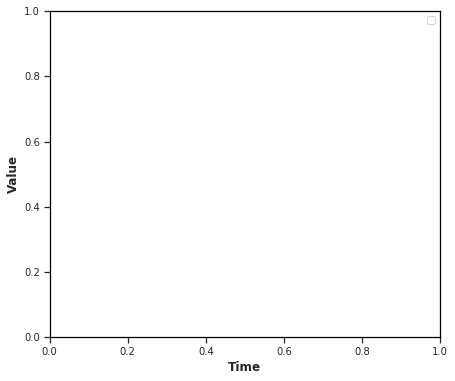

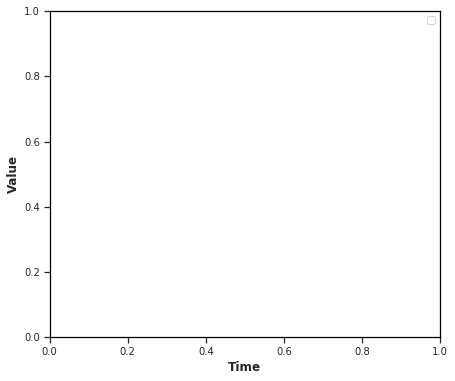

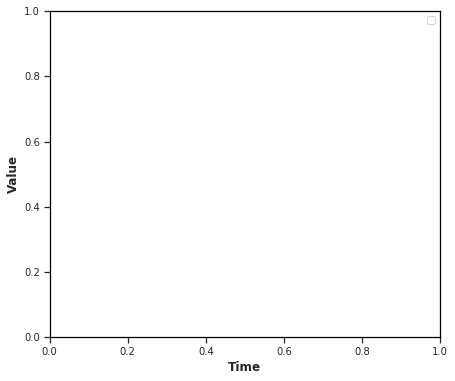

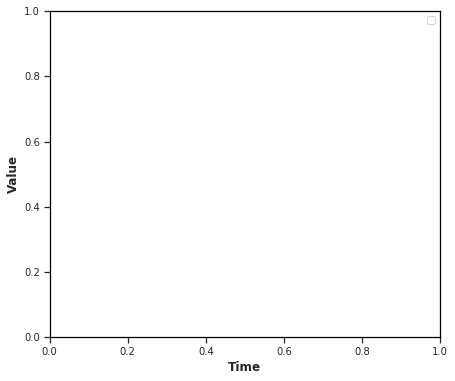

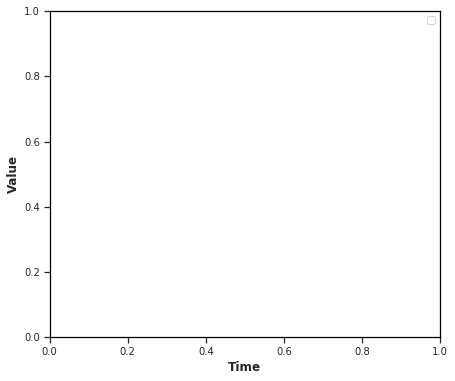

<IPython.core.display.Javascript object>

In [12]:
# quick, ugly check this is doing something sensible
if SHOW_PLOTS:
    tcre_diagnosis.filter(variable="Emis*CO2*", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Inverse Emis*CO2*", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Atmos*Conc*CO2", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Radiative Forcing", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Surface Temperature", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )

### ZEC

SR1.5 mentions a number of studies for its zero-emissions commitment assessment. Below we include them and our comments/summary of the experiments they performed.

Matthews and Caldeira 2008: instantaneous 50, 200, 500 and 2000 GtC pulses; historical CO2 concentrations until 2000 then RCP8.5 emissions with zero drops at 50, 200, 500 and 2000 GtC cumulative from 2005; historical CO2 concentrations until 2000 then linear drop with cumulative totals of 50, 200, 500 and 2000 GtC. Results show stabilisation with abrupt drops but temperature fit results imply a slightly positive ZEC for a smooth approach to a temperature target. In any case, they seem to have explored the question of ZEC in stabilisation scenarios somewhat already.

Lowe et al 2009: SRES A2 and then abrupt zero at 2012, 2050 or 2100. One extra scenario which has exponential drop in emissions. All seem to suggest negative ZEC.

Gillet et al 2011: abrupt zero at 2010 or 2100 from SRES A2

Collins et al 2013 (i.e. IPCC AR5 Ch.12, Section 12.5.2): variety of sources (including ones above but also more), conclude ZEC is slightly negative or zero (with positive bump for aerosols). Figure 12.44 is for abrupt zeros (although in case of RCP2.6 that isn't doing much for CO2) and exhibits negative ZEC. 

#### This study

Almost all of the studies above are CO$_2$ only and non-CO$_2$ is assessed elsewhere in the SR1.5 framework. To follow this, here we run RCP4.5 CO$_2$, global only emissions up until 2050 and then zero-emissions thereafter.

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


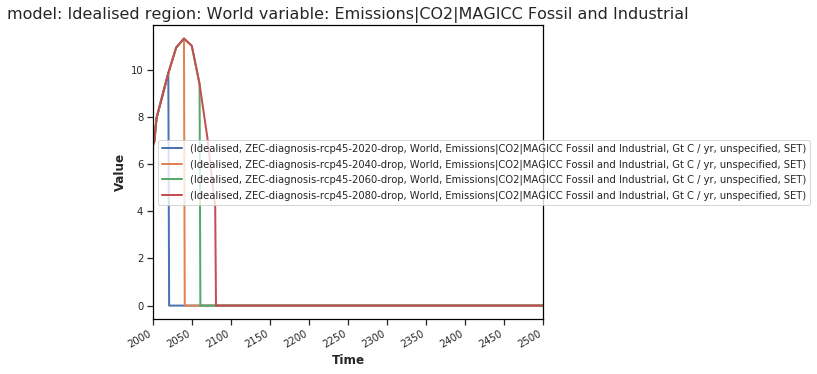

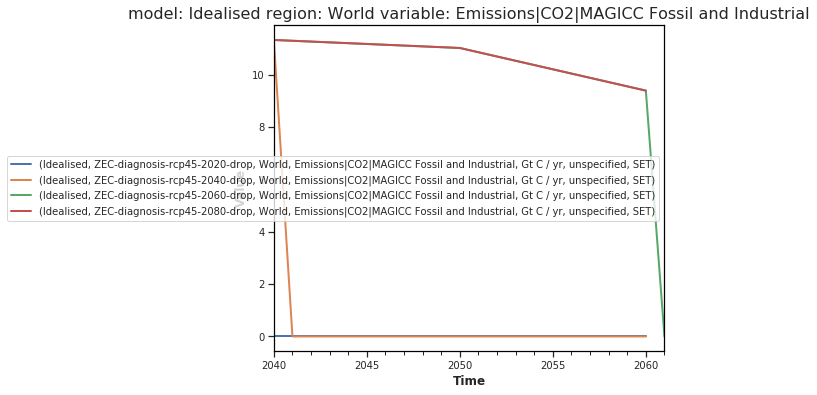

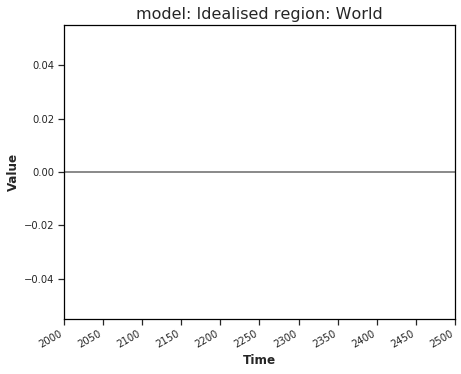

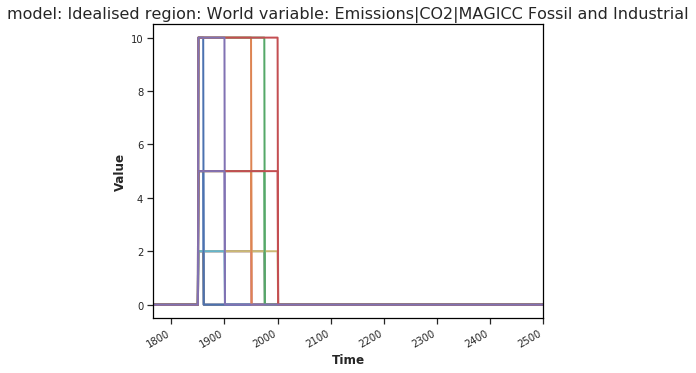

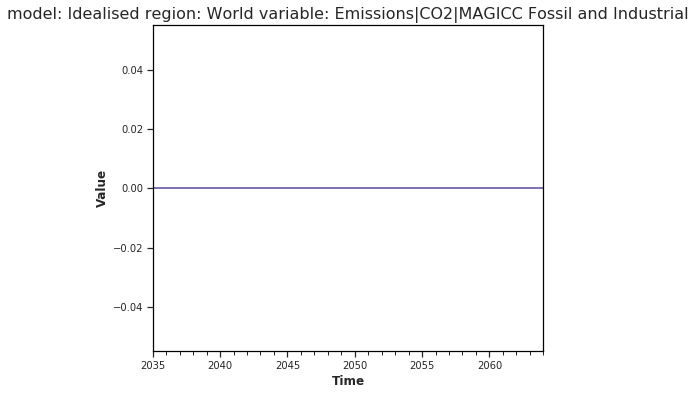

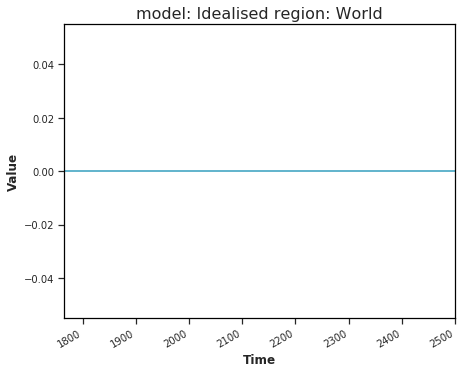

<IPython.core.display.Javascript object>

In [13]:
time = zero_emissions["time"]
zec_scens = []
for dropyear in np.arange(2020, 2081, 20):
    df = rcp45.filter(region="World", year=range(2000, 3000)).timeseries()
    df[datetime.datetime(dropyear + 1, 1, 1)] = 0
    df = df[sorted(df.columns)]
    df.loc[
        (
            df.index.get_level_values("variable")
            == "Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        [t.year > dropyear for t in df.columns],
    ] = 0
    df.loc[
        (
            df.index.get_level_values("variable")
            != "Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        :,
    ] = 0

    scen = MAGICCData(df)
    scen.set_meta("ZEC-diagnosis-rcp45-{}-drop".format(dropyear), "scenario")
    scen.set_meta(
        "Idealised", "model"
    )  # have to fill, None and nan don't work see https://github.com/openclimatedata/openscm/issues/114
    zec_scens.append(scen)

zec_scens = df_append(zec_scens)

zec_pulses = []
for pulseemissions in [2, 5, 10]:
    for pulselength in [10, 50, 100, 125, 150]:
        df = zero_emissions.filter(region="World").timeseries()
        df = df[sorted(df.columns)]
        df.loc[
            (
                df.index.get_level_values("variable")
                == "Emissions|CO2|MAGICC Fossil and Industrial"
            ),
            [1850 < t.year <= 1850 + pulselength for t in df.columns],
        ] = pulseemissions

        scen = MAGICCData(df)
        scen.set_meta(
            "ZEC-diagnosis-pulse-{}-for-{}-years".format(pulseemissions, pulselength),
            "scenario",
        )
        scen.set_meta(
            "Idealised", "model"
        )  # have to fill, None and nan don't work see https://github.com/openclimatedata/openscm/issues/114
        zec_pulses.append(scen)

zec_pulses = df_append(zec_pulses)

if SHOW_PLOTS:
    zec_scens.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
    zec_scens.filter(variable="Em*CO2*Fossil*", year=range(2035, 2065)).line_plot(
        x="time"
    )
    zec_scens.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time")

    zec_pulses.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
    zec_pulses.filter(variable="Em*CO2*Fossil*", year=range(2035, 2065)).line_plot(
        x="time"
    )
    zec_pulses.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time")

In [14]:
ZEC_SETTINGS = {
    "endyear": zec_scens["time"].max().year,
    "rf_total_constantafteryr": 5000,
    "rf_total_runmodus": "CO2",
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

<IPython.core.display.Javascript object>

In [15]:
for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**ZEC_SETTINGS, **cc_config}
    zec_diagnosis = run_magicc6_with_scenarios(zec_scens, settings)
    zec_diagnosis = zec_diagnosis.append(
        run_magicc6_with_scenarios(
            zec_pulses, settings, from_zero=True, test_run=TEST_RUN
        )
    )
    zec_diagnosis.set_meta(cc, "carbon_cycle_tuning")

    out_run_file = (
        OUTPUT_RUNS_ZEC
        if cc == "default"
        else OUTPUT_RUNS_ZEC.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(zec_diagnosis.filter(region="World"), out_run_file)
    
for j, (oc, oc_config) in enumerate(OCEAN_TUNINGS.items()):
    if TEST_RUN and j > 2 and oc != "default":
        continue
    print(oc)
    settings = {**ZEC_SETTINGS, **oc_config}
    zec_diagnosis = run_magicc6_with_scenarios(zec_scens, settings)
    zec_diagnosis = zec_diagnosis.append(
        run_magicc6_with_scenarios(
            zec_pulses, settings, from_zero=True, test_run=TEST_RUN
        )
    )
    zec_diagnosis.set_meta(oc, "ocean_tuning")

    out_run_file = (
        OUTPUT_RUNS_ZEC
        if oc == "default"
        else OUTPUT_RUNS_ZEC.replace(".h5", "_{}_ocean.h5".format(oc))
    )

    save_scmdataframe(zec_diagnosis.filter(region="World"), out_run_file)

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |                                           #       | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                          #        | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                          #                        | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |           #                                       | 6 Elapsed Time: 0:00:09Ignoring input data which

BERN


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                          #        | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                          #                        | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |           #                                       | 6 Elapsed Time: 0:00:09Ignoring input data which

LLNL


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                            #                      | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                           #       | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                           #       | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                             #                     | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |             #                                     | 6 Elapsed Time: 0:00:08Ignoring input data which

CCSM1


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                 #                                 | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                 #                 | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                 # | 3 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
/ |                                   #               | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                    #                              | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |     #                                             | 6 Elapsed Time: 0:00:09Ignoring input data which

CLIMBER


| |                                       #           | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                               #                   | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                         #         | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                          #                        | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |            #                                      | 6 Elapsed Time: 0:00:08Ignoring input data which

MPI


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                          #        | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                        #                          | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |        #                                          | 6 Elapsed Time: 0:00:09Ignoring input data which

FRCGC


| |                                     #             | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                 #                 | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                 # | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                     #             | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                      #                            | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |     #                                             | 6 Elapsed Time: 0:00:09Ignoring input data which

UMD2


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                               #   | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                      #            | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                      #                            | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |       #                                           | 6 Elapsed Time: 0:00:09Ignoring input data which

HADLEY


| |                                       #           | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                               #                   | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                       #           | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                        #                          | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |        #                                          | 6 Elapsed Time: 0:00:09Ignoring input data which

default


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                          #        | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                           #                       | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |            #                                      | 6 Elapsed Time: 0:00:08Ignoring input data which

CCCMA_CGCM3_1_T47


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                #                                  | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                               #                   | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                         #         | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                         #                         | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |           #                                       | 6 Elapsed Time: 0:00:09Ignoring input data which

CNRM_CM3


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                #                                  | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                 #                 | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                 # | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                   #               | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                    #                              | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |    #                                              | 6 Elapsed Time: 0:00:09Ignoring input data which

CSIRO_MK3_0


| |                                     #             | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                              #                    | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                       #           | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                       #                           | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |        #                                          | 6 Elapsed Time: 0:00:09Ignoring input data which

GFDL_CM2_0


| |                                     #             | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                               #   | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                     #             | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                      #                            | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |      #                                            | 6 Elapsed Time: 0:00:09Ignoring input data which

GFDL_CM2_1


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                #                  | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                 # | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                    #              | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                    #                              | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |   #                                               | 6 Elapsed Time: 0:00:09Ignoring input data which

GISS_MODEL_E_H


| |                                       #           | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                           #       | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                            #                      | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |             #                                     | 6 Elapsed Time: 0:00:08Ignoring input data which

GISS_MODEL_E_R


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                             #     | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                         #         | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                         #                         | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |         #                                         | 6 Elapsed Time: 0:00:09Ignoring input data which

IAP_FGOALS1_0_G


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                #                                  | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                   #               | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                  #| 3 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
/ |                                    #              | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                  #                                | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |   #                                               | 6 Elapsed Time: 0:00:09Ignoring input data which

INMCM3_0


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                              #                    | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                             #     | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                        #          | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                         #                         | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |         #                                         | 6 Elapsed Time: 0:00:09Ignoring input data which

IPSL_CM4


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                 #                                 | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                 #                 | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                  #| 3 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
/ |                                    #              | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                     #                             | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |      #                                            | 6 Elapsed Time: 0:00:09Ignoring input data which

MIROC3_2_HIRES


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                #                                  | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                              #                    | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                      #            | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                       #                           | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |        #                                          | 6 Elapsed Time: 0:00:09Ignoring input data which

MIROC3_2_MEDRES


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                  #                                | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                 #                 | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                #  | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                       #           | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                       #                           | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |       #                                           | 6 Elapsed Time: 0:00:09Ignoring input data which

MIUB_ECHO_G


| |                                       #           | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |                  #                                | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                                    #              | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                #  | 3 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
/ |                                #                  | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                 #                                 | 5 Elapsed Time: 0:00:08Ignoring input data which is not required for .SCEN file
\ |  #                                                | 6 Elapsed Time: 0:00:09Ignoring input data which

MPI_ECHAM5


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                               #                   | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                         #         | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                          #                        | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |            #                                      | 6 Elapsed Time: 0:00:08Ignoring input data which

MRI_CGCM2_3_2A


| |                                     #             | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                             #                     | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                                #  | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                     #             | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                       #                           | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |       #                                           | 6 Elapsed Time: 0:00:09Ignoring input data which

NCAR_CCSM3_0


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                               #                   | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                                #  | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                      #            | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                      #                            | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |      #                                            | 6 Elapsed Time: 0:00:09Ignoring input data which

NCAR_PCM1


| |                                       #           | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |              #                                    | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                            #                      | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                            #      | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                          #        | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                           #                       | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |            #                                      | 6 Elapsed Time: 0:00:08Ignoring input data which

UKMO_HADCM3


| |                                        #          | 3 Elapsed Time: 0:00:04
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                              #                    | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                              #    | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                        #          | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                         #                         | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |          #                                        | 6 Elapsed Time: 0:00:09Ignoring input data which

UKMO_HADGEM1


| |                                      #            | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |               #                                   | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                              #                    | 2 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
| |                                             #     | 3 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
/ |                                         #         | 4 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
- |                          #                        | 5 Elapsed Time: 0:00:07Ignoring input data which is not required for .SCEN file
\ |           #                                       | 6 Elapsed Time: 0:00:09Ignoring input data which

<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


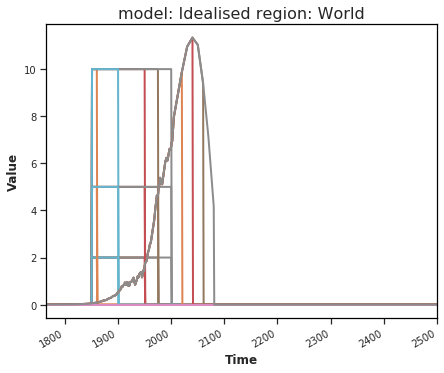

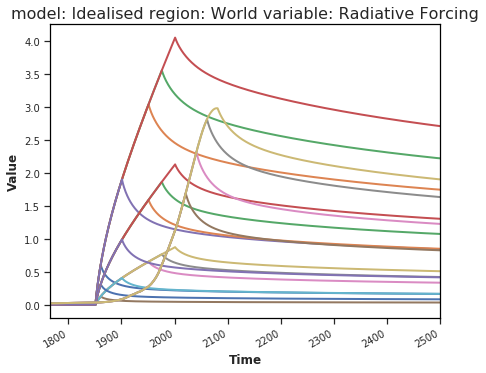

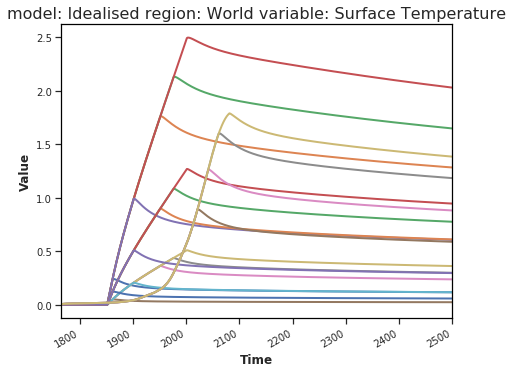

<IPython.core.display.Javascript object>

In [16]:
zec_diagnosis.filter(variable="Emis*CO2*", region="World").line_plot(x="time")
zec_diagnosis.filter(variable="Radiative Forcing", region="World").line_plot(
    x="time", color="scenario"
)
zec_diagnosis.filter(variable="Surface Temperature", region="World").line_plot(
    x="time", color="scenario"
)

### All drivers without permafrost

In [17]:
NO_PERMAFROST_SETTINGS = {  # defaults
    "endyear": 2105,
    "rf_total_runmodus": "all",
    "pf_apply": 0,
    "out_permafrost": 1,
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**NO_PERMAFROST_SETTINGS, **cc_config}
    no_permafrost = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    no_permafrost.set_meta(cc, "carbon_cycle_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_NO_PERMAFROST
        if cc == "default"
        else OUTPUT_RUNS_NO_PERMAFROST.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(
        no_permafrost.filter(year=range(1, 2101), region="World"), out_run_file
    )
    
for j, (oc, oc_config) in enumerate(OCEAN_TUNINGS.items()):
    if TEST_RUN and j > 2 and oc != "default":
        continue
    print(oc)
    settings = {**NO_PERMAFROST_SETTINGS, **oc_config}
    no_permafrost = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    no_permafrost.set_meta(oc, "ocean_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_NO_PERMAFROST
        if oc == "default"
        else OUTPUT_RUNS_NO_PERMAFROST.replace(".h5", "_{}_ocean.h5".format(oc))
    )

    save_scmdataframe(
        no_permafrost.filter(year=range(1, 2101), region="World"), out_run_file
    )

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |              #                                  | 410 Elapsed Time: 0:06:50
/ |#                                                  | 0 Elapsed Time: 0:00:00

BERN


| |                                     #           | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

LLNL


| |    #                                            | 410 Elapsed Time: 0:07:00
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCSM1


| |                                      #          | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

CLIMBER


| |                 #                               | 410 Elapsed Time: 0:06:59
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI


| |                                               # | 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

FRCGC


| |                          #                      | 410 Elapsed Time: 0:06:58
/ |#                                                  | 0 Elapsed Time: 0:00:00

UMD2


| |                                     #           | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

HADLEY


| | #                                               | 410 Elapsed Time: 0:07:01
/ |#                                                  | 0 Elapsed Time: 0:00:00

default


| |                  #                              | 410 Elapsed Time: 0:07:03
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCCMA_CGCM3_1_T47


| |                  #                              | 410 Elapsed Time: 0:06:59
/ |#                                                  | 0 Elapsed Time: 0:00:00

CNRM_CM3


| |                         #                       | 410 Elapsed Time: 0:06:54
/ |#                                                  | 0 Elapsed Time: 0:00:00

CSIRO_MK3_0


| |   #                                             | 410 Elapsed Time: 0:07:01
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_0


| |                               #                 | 410 Elapsed Time: 0:06:54
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_1


| | #                                               | 410 Elapsed Time: 0:06:51
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_H


| |                            #                    | 410 Elapsed Time: 0:06:48
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_R


| |         #                                       | 410 Elapsed Time: 0:06:50
/ |#                                                  | 0 Elapsed Time: 0:00:00

IAP_FGOALS1_0_G


| |                                  #              | 410 Elapsed Time: 0:06:55
/ |#                                                  | 0 Elapsed Time: 0:00:00

INMCM3_0


| |                                                #| 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

IPSL_CM4


| |      #                                          | 410 Elapsed Time: 0:06:50
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIROC3_2_HIRES


| |                                           #     | 410 Elapsed Time: 0:06:55
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIROC3_2_MEDRES


| |            #                                    | 410 Elapsed Time: 0:06:52
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIUB_ECHO_G


| |                                     #           | 410 Elapsed Time: 0:06:55
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI_ECHAM5


| |           #                                     | 410 Elapsed Time: 0:06:52
/ |#                                                  | 0 Elapsed Time: 0:00:00

MRI_CGCM2_3_2A


| |             #                                   | 410 Elapsed Time: 0:06:52
/ |#                                                  | 0 Elapsed Time: 0:00:00

NCAR_CCSM3_0


- |          #                                      | 389 Elapsed Time: 0:06:33

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
INFO:root:>=13 labels, not applying legend


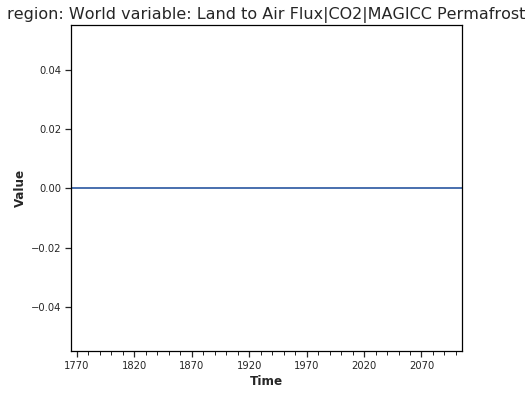

<IPython.core.display.Javascript object>

In [18]:
no_permafrost.filter(variable="*Permafrost*", region="World").line_plot(
    x="time", color="model"
)

### CO$_2$ only without permafrost

Here we examine the effect of non-CO$_2$ emissions from 2010 onwards. For each scenario, we do this by performing an experiment where we run with CO$_2$ emissions only and no permafrost.

In [19]:
CO2_ONLY_SETTINGS = {
    "endyear": 2105,
    "pf_apply": 0,
    "out_permafrost": 1,
    "rf_total_runmodus": "CO2",
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**CO2_ONLY_SETTINGS, **cc_config}
    co2_only = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    co2_only.set_meta(cc, "carbon_cycle_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_CO2_ONLY
        if cc == "default"
        else OUTPUT_RUNS_CO2_ONLY.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(
        co2_only.filter(year=range(1, 2101), region="World"), out_run_file
    )
    
for j, (oc, oc_config) in enumerate(OCEAN_TUNINGS.items()):
    if TEST_RUN and j > 2 and oc != "default":
        continue
    print(oc)
    settings = {**CO2_ONLY_SETTINGS, **oc_config}
    co2_only = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    co2_only.set_meta(oc, "ocean_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_CO2_ONLY
        if oc == "default"
        else OUTPUT_RUNS_CO2_ONLY.replace(".h5", "_{}_ocean.h5".format(oc))
    )

    save_scmdataframe(
        co2_only.filter(year=range(1, 2101), region="World"), out_run_file
    )

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| | #                                               | 410 Elapsed Time: 0:06:51
/ |#                                                  | 0 Elapsed Time: 0:00:00

BERN


| |              #                                  | 410 Elapsed Time: 0:06:53
/ |#                                                  | 0 Elapsed Time: 0:00:00

LLNL


| |    #                                            | 410 Elapsed Time: 0:06:52
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCSM1


| |#                                                | 410 Elapsed Time: 0:06:51
/ |#                                                  | 0 Elapsed Time: 0:00:00

CLIMBER


| |          #                                      | 410 Elapsed Time: 0:07:00
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI


| |                                        #        | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

FRCGC


| |                                            #    | 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

UMD2


| |                  #                              | 410 Elapsed Time: 0:06:53
/ |#                                                  | 0 Elapsed Time: 0:00:00

HADLEY


| |                                         #       | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

default


| |                            #                    | 410 Elapsed Time: 0:06:58
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCCMA_CGCM3_1_T47


| |                                            #    | 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

CNRM_CM3


| |               #                                 | 410 Elapsed Time: 0:06:53
/ |#                                                  | 0 Elapsed Time: 0:00:00

CSIRO_MK3_0


| |           #                                     | 410 Elapsed Time: 0:07:10
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_0


| |                                            #    | 410 Elapsed Time: 0:07:06
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_1


| |                                               # | 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_H


| |                                           #     | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_R


| |                           #                     | 410 Elapsed Time: 0:06:54
/ |#                                                  | 0 Elapsed Time: 0:00:00

IAP_FGOALS1_0_G


| |                            #                    | 410 Elapsed Time: 0:06:54
/ |#                                                  | 0 Elapsed Time: 0:00:00

INMCM3_0


| |                   #                             | 410 Elapsed Time: 0:06:53
/ |#                                                  | 0 Elapsed Time: 0:00:00

IPSL_CM4


| |     #                                           | 410 Elapsed Time: 0:06:52
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIROC3_2_HIRES


| |                                           #     | 410 Elapsed Time: 0:06:57
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIROC3_2_MEDRES


| |                                             #   | 410 Elapsed Time: 0:06:56
/ |#                                                  | 0 Elapsed Time: 0:00:00

MIUB_ECHO_G


| | #                                               | 410 Elapsed Time: 0:06:51
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI_ECHAM5


| |                                #                | 410 Elapsed Time: 0:06:58
/ |#                                                  | 0 Elapsed Time: 0:00:00

MRI_CGCM2_3_2A


| |                                          #      | 410 Elapsed Time: 0:06:55
/ |#                                                  | 0 Elapsed Time: 0:00:00

NCAR_CCSM3_0


| |#                                                | 410 Elapsed Time: 0:06:51
/ |#                                                  | 0 Elapsed Time: 0:00:00

NCAR_PCM1


/ |                     #                           | 224 Elapsed Time: 0:03:43

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


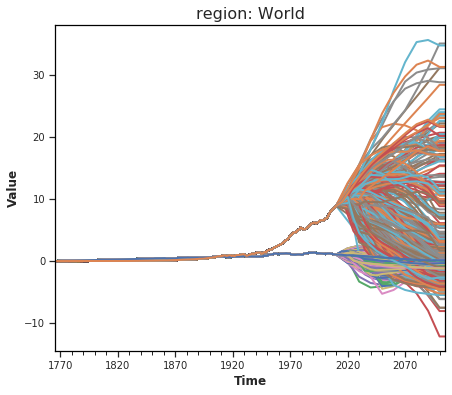

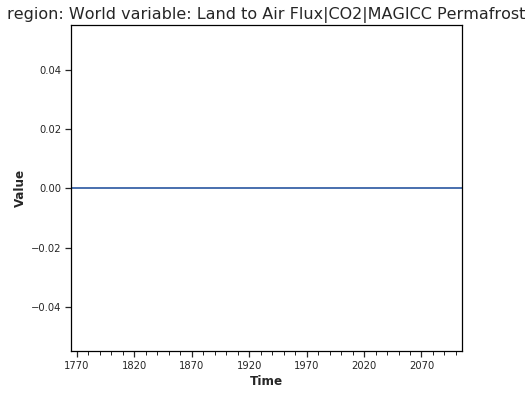

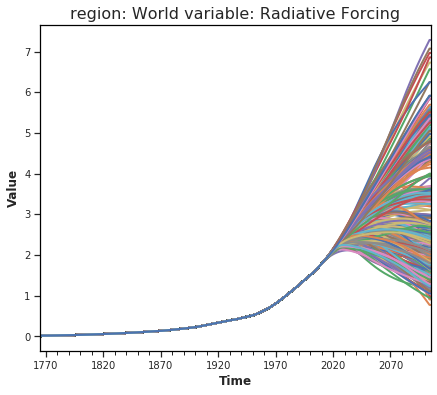

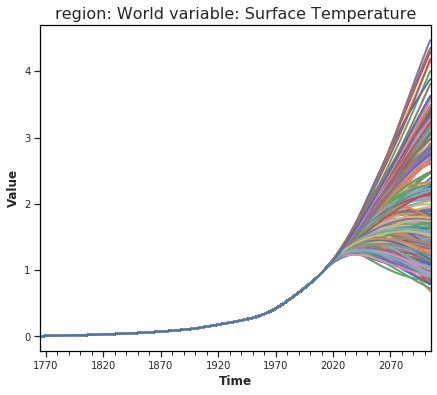

<IPython.core.display.Javascript object>

In [20]:
co2_only.filter(variable="Emis*CO2*", region="World").line_plot(x="time")
co2_only.filter(variable="*Permafrost", region="World").line_plot(x="time")
co2_only.filter(variable="Radiative Forcing", region="World").line_plot(x="time")
co2_only.filter(variable="Surface Temperature", region="World").line_plot(x="time")